In [6]:
import networkx as nx
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
lattice = nx.lattice.grid_2d_graph(n=10, m=10, periodic=True)
lattice = lattice

In [3]:
def to_gset(gfile: str, g: nx.Graph):
    with open(gfile, mode='w') as gset:
        gset.write('{} {}\n'.format(g.number_of_nodes(), g.number_of_edges()))
        edgelist = g.edges()
        n = g.number_of_nodes()
        for u,v in g.edges():
            src = u[0] * 10 + u[1]
            dst = v[0] * 10 + v[1]
            gset.write('{} {} 1\n'.format(src, dst)) 

In [38]:
to_gset('../lattice_2d.gset', lattice)

In [39]:
lattice.edges()


EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 0), (9, 0)), ((0, 0), (0, 9)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 1), (9, 1)), ((0, 2), (1, 2)), ((0, 2), (0, 3)), ((0, 2), (9, 2)), ((0, 3), (1, 3)), ((0, 3), (0, 4)), ((0, 3), (9, 3)), ((0, 4), (1, 4)), ((0, 4), (0, 5)), ((0, 4), (9, 4)), ((0, 5), (1, 5)), ((0, 5), (0, 6)), ((0, 5), (9, 5)), ((0, 6), (1, 6)), ((0, 6), (0, 7)), ((0, 6), (9, 6)), ((0, 7), (1, 7)), ((0, 7), (0, 8)), ((0, 7), (9, 7)), ((0, 8), (1, 8)), ((0, 8), (0, 9)), ((0, 8), (9, 8)), ((0, 9), (1, 9)), ((0, 9), (9, 9)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 0), (1, 9)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((1, 2), (1, 3)), ((1, 3), (2, 3)), ((1, 3), (1, 4)), ((1, 4), (2, 4)), ((1, 4), (1, 5)), ((1, 5), (2, 5)), ((1, 5), (1, 6)), ((1, 6), (2, 6)), ((1, 6), (1, 7)), ((1, 7), (2, 7)), ((1, 7), (1, 8)), ((1, 8), (2, 8)), ((1, 8), (1, 9)), ((1, 9), (2, 9)), ((2, 0), (3, 0)), ((2, 0), (2, 1)), ((2, 0), (2, 9)), ((2, 1), (3, 1)), ((2, 1), (2, 2)), 

In [50]:
files = [os.path.abspath('../data/'+i) for i in os.listdir('../data')]
dflist = [pd.read_csv(i) for i in files]
df = pd.concat(dflist)
df

,epoch,beta,M,ene
0,0,0.0001,0.0004,4
1,1,0.0102,0.0004,-32
2,2,0.0203,0.0036,16
3,3,0.0304,0.0036,20
4,4,0.0405,0.0004,-4
...,...,...,...,...
95,95,0.9596,1.0000,-200
96,96,0.9697,1.0000,-200
97,97,0.9798,1.0000,-200
98,98,0.9899,1.0000,-200


In [51]:
mean_df = df.groupby('beta').mean().reset_index()

In [52]:
mean_df['$\sqrt{M}$'] = np.sqrt(mean_df['M'])

<AxesSubplot: xlabel='beta', ylabel='$\\sqrt{M}$'>

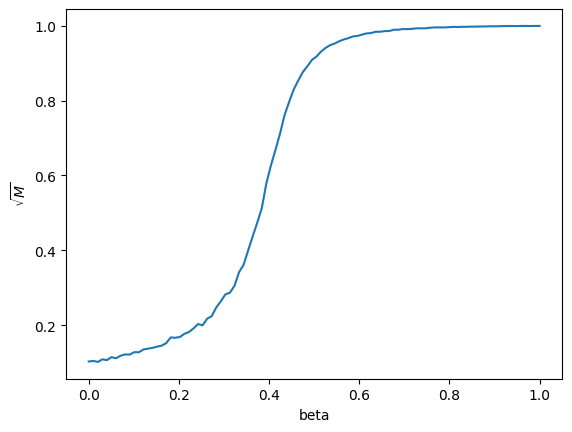

In [54]:
sns.lineplot(data=mean_df, x='beta', y='$\sqrt{M}$')

<AxesSubplot: xlabel='beta', ylabel='ene'>

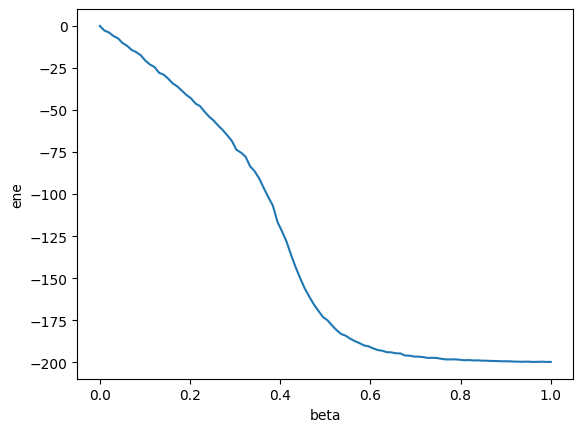

In [55]:
sns.lineplot(data=mean_df, x='beta', y='ene')

In [56]:
# df.to_csv('full_active_2d.csv', index=False)